In [1]:
import time
start_time = time.time()
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from functools import partial

In [3]:
from sklearn.datasets import load_iris
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)
num_features = features.shape[1]

In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

iris_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

iris_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=iris_feature_map)

In [5]:
data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

In [6]:
full_features = iris_data.data 

In [8]:
from qiskit_machine_learning.algorithms import QSVC

qsvc_full = QSVC(quantum_kernel=iris_kernel, probability=True)

qsvc_full.fit(train_features, train_labels)

qsvc_score = qsvc_full.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")
#qsvc_full.save('quantum_classifiers/iris_qsvc.model')

QSVC classification test score: 0.8666666666666667


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals
import time

qsvc_scores = {}
training_times = {}

for i, description in enumerate(data_descriptions):
    
    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i-1, axis=1)
    
    
    num_features = adjusted_features.shape[1]
    
    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    iris_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")
    iris_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=iris_feature_map)
    qsvc = QSVC(quantum_kernel=iris_kernel)
    
    
    start_time = time.time()
    qsvc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    training_times[description] = elapsed_time
    
    # Evaluate model performance
    qsvc_score = qsvc.score(test_features, test_labels)
    qsvc_scores[description] = qsvc_score
    
    print(f"{description} - QSVC classification test score: {qsvc_score}, Training time: {elapsed_time:.2f} seconds")

Full Features - QSVC classification test score: 0.8666666666666667, Training time: 40.23 seconds
Missing Sepal Length - QSVC classification test score: 0.9, Training time: 30.03 seconds
Missing Sepal Width - QSVC classification test score: 0.8666666666666667, Training time: 31.13 seconds
Missing Petal Length - QSVC classification test score: 0.9, Training time: 29.63 seconds
Missing Petal Width - QSVC classification test score: 0.8666666666666667, Training time: 30.15 seconds


In [15]:
qsvc_scores

{'Full Features': 0.8666666666666667,
 'Missing Sepal Length': 0.9,
 'Missing Sepal Width': 0.8666666666666667,
 'Missing Petal Length': 0.9,
 'Missing Petal Width': 0.8666666666666667}

In [16]:
df = pd.DataFrame(list(qsvc_scores.items()), columns=['Description', 'Test Score'])
df.to_csv('qsvc_loo_scores.csv', index=False)

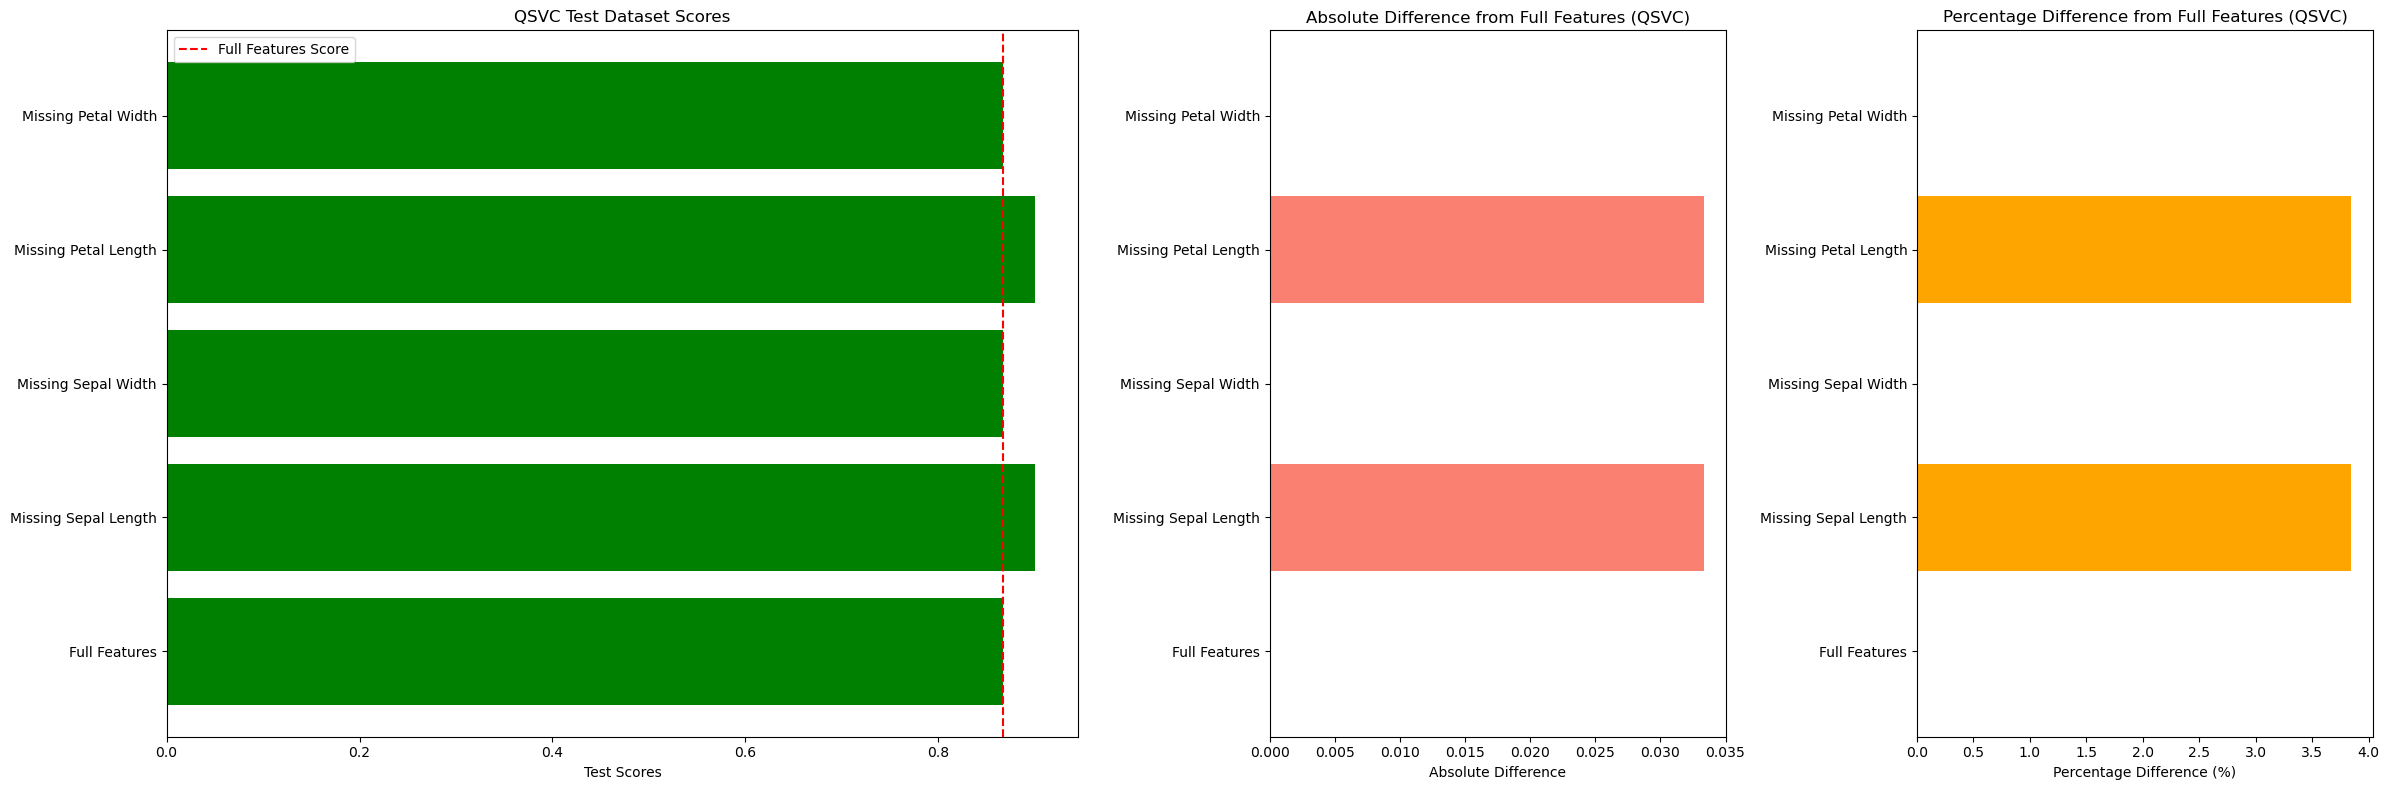

In [17]:

qscores = {
    'Full Features': {'Test': 0.8666666666666667, 'Training Time': 50.44},
    'Missing Sepal Length': {'Test': 0.9, 'Training Time': 38.94},
    'Missing Sepal Width': {'Test': 0.8666666666666667, 'Training Time': 34.46},
    'Missing Petal Length': {'Test': 0.9, 'Training Time': 34.90},
    'Missing Petal Width': {'Test': 0.8666666666666667, 'Training Time': 33.74}
}


qfull_feature_score = qscores['Full Features']['Test']
for feature_set, score_info in qscores.items():
    if feature_set != 'Full Features':
        qabsolute_difference = score_info['Test'] - qfull_feature_score 
        qpercentage_difference = (qabsolute_difference / qfull_feature_score) * 100
        qscores[feature_set]['Absolute Difference'] = qabsolute_difference
        qscores[feature_set]['Percentage Difference'] = qpercentage_difference


qcategories = list(qscores.keys())
qtest_scores = [score_info['Test'] for score_info in qscores.values()]
qabs_diff_scores = [score_info.get('Absolute Difference', 0) for score_info in qscores.values()]
qperc_diff_scores = [score_info.get('Percentage Difference', 0) for score_info in qscores.values()]
qtraining_times = [score_info['Training Time'] for score_info in qscores.values()]


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 1, 1]})


ax1.barh(qcategories, qtest_scores, color='green')
ax1.axvline(x=qfull_feature_score, color='red', linestyle='--', label='Full Features Score')
ax1.set_xlabel('Test Scores')
ax1.set_title('QSVC Test Dataset Scores')
ax1.legend()


ax2.barh(qcategories, qabs_diff_scores, color='salmon')
ax2.set_xlabel('Absolute Difference')
ax2.set_title('Absolute Difference from Full Features (QSVC)')


ax3.barh(qcategories, qperc_diff_scores, color='orange')
ax3.set_xlabel('Percentage Difference (%)')
ax3.set_title('Percentage Difference from Full Features (QSVC)')


plt.tight_layout()

plt.show()

In [18]:
end_time = time.time()
total_runtime = end_time - start_time
print(f"Total Notebook Runtime: {total_runtime} seconds")

Total Notebook Runtime: 584.9167828559875 seconds
